# Unet from Aladdin 

In [17]:
!wget https://www.dropbox.com/s/tc1qo73rrm3gt3m/CARVANA.zip

!unzip -q CARVANA.zip -d CARVANA

!rm -rf ./train/.DS_Store
!rm -rf ./train_masks/.DS_Store
!rm -rf CARVANA.zip


--2023-05-17 09:39:42--  https://www.dropbox.com/s/tc1qo73rrm3gt3m/CARVANA.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/tc1qo73rrm3gt3m/CARVANA.zip [following]
--2023-05-17 09:39:42--  https://www.dropbox.com/s/raw/tc1qo73rrm3gt3m/CARVANA.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc5981cae3f1842c7208fde02e31.dl.dropboxusercontent.com/cd/0/inline/B8MNJiQdFw-QIdChc-a2hpqPqerYnIKU5Az025SPXiSN96ICxVmfJK0xS24xObT74OWVTvCwAYKL93DD8E_H4_lIzrvG_V0MSOBiB8YtHuMpsU0uCxOrNHUdF-aNYSD-IJRQy9bR31xw_mG8gOlmUfk9h6FEHLf4kwKLFdeu_YBYeg/file# [following]
--2023-05-17 09:39:43--  https://uc5981cae3f1842c7208fde02e31.dl.dropboxusercontent.com/cd/0/inline/B8MNJiQdFw-QIdChc-a2hpqPqerYnIKU5Az025SPXiSN96ICxVmfJK0xS24xObT74OWVTvCwAYKL93DD8E_

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms.functional as TF

import glob
import os
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import numpy as np


import torch.optim as optim
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Model


Double Convolution as building brick

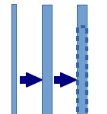

In [2]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False), # bias=False for Batchnorm              
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

In [3]:
class UNET(nn.Module):
    def __init__(
            self, in_channels=3, out_channels=1, features=[64, 128, 256, 512],
    ):
        super(UNET, self).__init__()
        
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET - only left side 
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET - only right side 
        for feature in reversed(features):
            # up             
            self.ups.append(
                nn.ConvTranspose2d(
                    # with skip-conn
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            # two times right             
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

        
    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        
        # reverse skip_connections 
        skip_connections = skip_connections[::-1]
            
                        # пропускаем DoubleConv        
        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            # resize if x does not match skip_conn              
            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:], antialias=True)

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

In [4]:
def test():
    x = torch.randn((3, 1, 161, 161))
    model = UNET(in_channels=1, out_channels=1)
    preds = model(x)
    assert preds.shape == x.shape

test()

## Dataset 

In [5]:
class CarvanaDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.images[index])
        mask_path = os.path.join(self.mask_dir, self.images[index].replace(".jpg", "_mask.gif"))
        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"), dtype=np.float32)
        # for sigmoid         
        mask[mask == 255.0] = 1.0
        
        if self.transform is not None:
            augmentations = self.transform(image=image, mask=mask)
            image = augmentations["image"]
            mask = augmentations["mask"]

        return image, mask

In [6]:
class SegmentationDataset(torch.utils.data.Dataset):
    def __init__(self,
                 slices_dir,
                 masks_dir,
                 transforms):
        
        self.slices_dir = sorted(glob.glob(os.path.join(slices_dir, "*.png")))      
        self.masks_dir = sorted(glob.glob(os.path.join(masks_dir, "*.png")))      
        self.transforms = transforms

        assert len(self.slices_dir) == len(self.masks_dir)

        

    def __getitem__(self, idx):
        img = np.array(Image.open(self.slices_dir[idx]))
        mask = np.array(Image.open(self.masks_dir[idx]))
 
        mask[mask == 255.0] = 1.0
        augmentations = self.transforms(image=img, mask=mask)
        image = augmentations["image"]
        mask = augmentations["mask"]
        mask = torch.unsqueeze(mask, 0)
        mask = mask.type(torch.uint8)
        return image, mask

    def __len__(self):
        return len(self.slices_dir)

## Utils

In [7]:
def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)

def load_checkpoint(checkpoint, model):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])

Loaders located here

In [8]:
def create_datasets(masks_dir, slices_dir, augmentations):
    train_dataset = SegmentationDataset(
                 slices_dir=slices_dir + "/train", 
                 masks_dir=masks_dir + "/train",
                 transforms=augmentations)

    val_dataset = SegmentationDataset(
                     slices_dir=slices_dir + "/val", 
                     masks_dir=masks_dir + "/val",
                     transforms=augmentations)

    test_dataset = SegmentationDataset(
                     slices_dir=slices_dir + "/test", 
                     masks_dir=masks_dir + "/test",
                     transforms=augmentations)

    print(f"Train size: {len(train_dataset)}")
    print(f"Valid size: {len(val_dataset)}")
    print(f"Test size:  {len(test_dataset)}")
        
    return train_dataset, val_dataset, test_dataset


def create_dataloaders(train_dataset, val_dataset, test_dataset, 
                       batch_size=8, shuffle=True, pin_memory=True, num_workers=4):

    train_loader = torch.utils.data.DataLoader(
        dataset=train_dataset, batch_size=batch_size, 
        shuffle=shuffle, pin_memory=pin_memory, num_workers=num_workers)

    val_loader = torch.utils.data.DataLoader(
        dataset=val_dataset, batch_size=batch_size, 
        shuffle=shuffle, pin_memory=pin_memory, num_workers=num_workers
    )

    test_loader = torch.utils.data.DataLoader(
        dataset=test_dataset, batch_size=batch_size, 
        shuffle=shuffle, pin_memory=pin_memory, num_workers=num_workers
    )
    return train_loader, val_loader, test_loader

In [ ]:
def get_loaders(
    train_dir,
    train_maskdir,
    val_dir,
    val_maskdir,
    batch_size,
    train_transform,
    val_transform,
    num_workers=4,
    pin_memory=True,
):
    
    
    train_ds = CarvanaDataset(
        image_dir=train_dir,
        mask_dir=train_maskdir,
        transform=train_transform,
    )

    train_loader = DataLoader(
        train_ds,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=True,
    )

    val_ds = CarvanaDataset(
        image_dir=val_dir,
        mask_dir=val_maskdir,
        transform=val_transform,
    )

    val_loader = DataLoader(
        val_ds,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=False,
    )

    return train_loader, val_loader

In [9]:
def check_accuracy(loader, model, device="cuda"):
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device).unsqueeze(1) # label does not have chanel
            
            # getting probs             
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
            
            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)
            dice_score += (2 * (preds * y).sum()) / (
                (preds + y).sum() + 1e-8
            )

    print(
        f"Got {num_correct}/{num_pixels} with acc {num_correct/num_pixels*100:.2f}"
    )
    print(f"Dice score: {dice_score/len(loader)}")
    model.train()

def save_predictions_as_imgs(
    loader, model, folder="saved_images/", device="cuda"
):
    model.eval()
    for idx, (x, y) in enumerate(loader):
        x = x.to(device=device)
        with torch.no_grad():
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
        torchvision.utils.save_image(
            preds, f"{folder}/pred_{idx}.png"
        )
        torchvision.utils.save_image(y.unsqueeze(1), f"{folder}{idx}.png")

    model.train()

## Train part

1. Settings

In [10]:
# Hyperparameters etc.
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

LEARNING_RATE = 1e-4
BATCH_SIZE = 16
NUM_EPOCHS = 100
NUM_WORKERS = 2
IMAGE_HEIGHT = 256  # 1280 originally
IMAGE_WIDTH = 256  # 1918 originally

PIN_MEMORY = True
LOAD_MODEL = False
# 
MASKS = "/kaggle/input/stroke-aid-dataset-splitted/masks"
SLICES = "/kaggle/input/stroke-aid-dataset-splitted/slices"


# TRAIN_IMG_DIR = "CARVANA/train/"
# TRAIN_MASK_DIR = "CARVANA/train_masks/"
# VAL_IMG_DIR = "data/val_images/"
# VAL_MASK_DIR = "data/val_masks/"

2. Data augmentations

In [11]:
train_transform = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.Rotate(limit=35, p=1.0),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.1),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ],
)

val_transforms = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ],
)

3. Let's create model

In [12]:
model = UNET(in_channels=3, out_channels=1).to(DEVICE)
                # WithLogits for making sigmoid   
                # or use torch.sigmoid() on the end of forward in model   
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

scaler = torch.cuda.amp.GradScaler()

3. 1. If model has checkpoint

In [ ]:
CHECKPOINT_NAME = "my_checkpoint.pth.tar"
if LOAD_MODEL:
    load_checkpoint(torch.load(CHECKPOINT_NAME), model)

check_accuracy(val_loader, model, device=DEVICE)

4. Creating Loaders

In [14]:
train_dataset, val_dataset, test_dataset = create_datasets(MASKS, SLICES, train_transform)

train_loader, val_loader, test_loader = create_dataloaders(train_dataset, val_dataset, test_dataset, batch_size=BATCH_SIZE, pin_memory=PIN_MEMORY, num_workers=NUM_WORKERS)

Train size: 450
Valid size: 148
Test size:  149


In [24]:
# train_loader, val_loader = get_loaders(
#     IMG_DIR,
#     MASK_DIR, 
    
# #     TRAIN_IMG_DIR,
# #     TRAIN_MASK_DIR,
# #     VAL_IMG_DIR,
# #     VAL_MASK_DIR,
    
#     BATCH_SIZE,
#     train_transform,
#     val_transforms,
#     NUM_WORKERS,
#     PIN_MEMORY,
# )

5. Training itself

In [15]:
def train_fn(loader, model, optimizer, loss_fn, scaler):
    loop = tqdm(loader)
    # подгружаем лоадер     
    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device=DEVICE)
                        # for bce   # for additional dim 
#         targets = targets.float().unsqueeze(1).to(device=DEVICE)
        targets = targets.float().to(device=DEVICE)

        # forward
        # float16 training (separate video)          
        with torch.cuda.amp.autocast():
            predictions = model(data)
            loss = loss_fn(predictions, targets)

        # backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # update tqdm loop
        loop.set_postfix(loss=loss.item())

In [16]:
for epoch in range(NUM_EPOCHS):
    train_fn(train_loader, model, optimizer, loss_fn, scaler)

    # save model
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer":optimizer.state_dict(),
    }
    save_checkpoint(checkpoint)

    # check accuracy
    check_accuracy(val_loader, model, device=DEVICE)

    # print some examples to a folder
#     save_predictions_as_imgs(
#         val_loader, model, folder="saved_images/", device=DEVICE
#     )

100%|██████████| 29/29 [00:18<00:00,  1.56it/s, loss=0.419]


=> Saving checkpoint
Got 149106108/9699328 with acc 1537.28
Dice score: 0.0


100%|██████████| 29/29 [00:15<00:00,  1.89it/s, loss=0.348]


=> Saving checkpoint
Got 146567326/9699328 with acc 1511.11
Dice score: 0.005297193769365549


100%|██████████| 29/29 [00:15<00:00,  1.90it/s, loss=0.328]


=> Saving checkpoint
Got 149207466/9699328 with acc 1538.33
Dice score: 0.06127449497580528


100%|██████████| 29/29 [00:15<00:00,  1.91it/s, loss=0.328]


=> Saving checkpoint
Got 149446494/9699328 with acc 1540.79
Dice score: 0.0682467371225357


100%|██████████| 29/29 [00:15<00:00,  1.84it/s, loss=0.292]


=> Saving checkpoint
Got 149112646/9699328 with acc 1537.35
Dice score: 0.07460906356573105


100%|██████████| 29/29 [00:15<00:00,  1.89it/s, loss=0.274]


=> Saving checkpoint
Got 149244186/9699328 with acc 1538.71
Dice score: 0.07964151352643967


100%|██████████| 29/29 [00:15<00:00,  1.91it/s, loss=0.306]


=> Saving checkpoint
Got 149654292/9699328 with acc 1542.93
Dice score: 0.06144753843545914


100%|██████████| 29/29 [00:15<00:00,  1.90it/s, loss=0.249]


=> Saving checkpoint
Got 149534690/9699328 with acc 1541.70
Dice score: 0.07470861077308655


100%|██████████| 29/29 [00:15<00:00,  1.89it/s, loss=0.239]


=> Saving checkpoint
Got 148467478/9699328 with acc 1530.70
Dice score: 0.08267156034708023


100%|██████████| 29/29 [00:15<00:00,  1.89it/s, loss=0.339]


=> Saving checkpoint
Got 149513246/9699328 with acc 1541.48
Dice score: 0.07219865173101425


100%|██████████| 29/29 [00:15<00:00,  1.89it/s, loss=0.247]


=> Saving checkpoint
Got 147041428/9699328 with acc 1516.00
Dice score: 0.08501455187797546


100%|██████████| 29/29 [00:15<00:00,  1.90it/s, loss=0.204]


=> Saving checkpoint
Got 149549972/9699328 with acc 1541.86
Dice score: 0.07341548055410385


100%|██████████| 29/29 [00:15<00:00,  1.89it/s, loss=0.21] 


=> Saving checkpoint
Got 149845648/9699328 with acc 1544.91
Dice score: 0.0488058440387249


100%|██████████| 29/29 [00:15<00:00,  1.91it/s, loss=0.19] 


=> Saving checkpoint
Got 148961454/9699328 with acc 1535.79
Dice score: 0.07599061727523804


100%|██████████| 29/29 [00:15<00:00,  1.83it/s, loss=0.179]


=> Saving checkpoint
Got 148799096/9699328 with acc 1534.12
Dice score: 0.08955573290586472


100%|██████████| 29/29 [00:15<00:00,  1.89it/s, loss=0.207]


=> Saving checkpoint
Got 149717986/9699328 with acc 1543.59
Dice score: 0.062550388276577


100%|██████████| 29/29 [00:15<00:00,  1.89it/s, loss=0.188]


=> Saving checkpoint
Got 141851504/9699328 with acc 1462.49
Dice score: 0.07137368619441986


100%|██████████| 29/29 [00:15<00:00,  1.85it/s, loss=0.194]


=> Saving checkpoint
Got 148832852/9699328 with acc 1534.47
Dice score: 0.09212605655193329


100%|██████████| 29/29 [00:15<00:00,  1.90it/s, loss=0.182]


=> Saving checkpoint
Got 149316880/9699328 with acc 1539.46
Dice score: 0.08444484323263168


100%|██████████| 29/29 [00:15<00:00,  1.85it/s, loss=0.154]


=> Saving checkpoint
Got 145725350/9699328 with acc 1502.43
Dice score: 0.08911973983049393


100%|██████████| 29/29 [00:15<00:00,  1.89it/s, loss=0.136]


=> Saving checkpoint
Got 148262392/9699328 with acc 1528.58
Dice score: 0.09080895036458969


100%|██████████| 29/29 [00:15<00:00,  1.90it/s, loss=0.15] 


=> Saving checkpoint
Got 149620456/9699328 with acc 1542.59
Dice score: 0.06598937511444092


100%|██████████| 29/29 [00:15<00:00,  1.89it/s, loss=0.127]


=> Saving checkpoint
Got 144441350/9699328 with acc 1489.19
Dice score: 0.0919354185461998


100%|██████████| 29/29 [00:15<00:00,  1.89it/s, loss=0.171]


=> Saving checkpoint
Got 148714944/9699328 with acc 1533.25
Dice score: 0.08518090099096298


100%|██████████| 29/29 [00:15<00:00,  1.89it/s, loss=0.118]


=> Saving checkpoint
Got 149489706/9699328 with acc 1541.24
Dice score: 0.08559621870517731


100%|██████████| 29/29 [00:15<00:00,  1.90it/s, loss=0.153]


=> Saving checkpoint
Got 148360964/9699328 with acc 1529.60
Dice score: 0.09348103404045105


100%|██████████| 29/29 [00:15<00:00,  1.91it/s, loss=0.151]


=> Saving checkpoint
Got 148808756/9699328 with acc 1534.22
Dice score: 0.09850683063268661


100%|██████████| 29/29 [00:15<00:00,  1.89it/s, loss=0.106]


=> Saving checkpoint
Got 148588614/9699328 with acc 1531.95
Dice score: 0.08974850177764893


100%|██████████| 29/29 [00:15<00:00,  1.90it/s, loss=0.138] 


=> Saving checkpoint
Got 147911960/9699328 with acc 1524.97
Dice score: 0.07704195380210876


100%|██████████| 29/29 [00:15<00:00,  1.88it/s, loss=0.153] 


=> Saving checkpoint
Got 148958708/9699328 with acc 1535.76
Dice score: 0.06593567878007889


100%|██████████| 29/29 [00:15<00:00,  1.90it/s, loss=0.104] 


=> Saving checkpoint
Got 149077102/9699328 with acc 1536.98
Dice score: 0.0901559367775917


100%|██████████| 29/29 [00:15<00:00,  1.90it/s, loss=0.119] 


=> Saving checkpoint
Got 148718920/9699328 with acc 1533.29
Dice score: 0.08169713616371155


100%|██████████| 29/29 [00:15<00:00,  1.89it/s, loss=0.104] 


=> Saving checkpoint
Got 147925994/9699328 with acc 1525.12
Dice score: 0.09339257329702377


100%|██████████| 29/29 [00:15<00:00,  1.90it/s, loss=0.0814]


=> Saving checkpoint
Got 148814994/9699328 with acc 1534.28
Dice score: 0.09369602799415588


100%|██████████| 29/29 [00:15<00:00,  1.90it/s, loss=0.101] 


=> Saving checkpoint
Got 149475552/9699328 with acc 1541.09
Dice score: 0.07429879903793335


100%|██████████| 29/29 [00:15<00:00,  1.91it/s, loss=0.0732]


=> Saving checkpoint
Got 149066128/9699328 with acc 1536.87
Dice score: 0.08784877508878708


100%|██████████| 29/29 [00:15<00:00,  1.89it/s, loss=0.117] 


=> Saving checkpoint
Got 148405436/9699328 with acc 1530.06
Dice score: 0.09026934951543808


100%|██████████| 29/29 [00:15<00:00,  1.90it/s, loss=0.0697]


=> Saving checkpoint
Got 148640974/9699328 with acc 1532.49
Dice score: 0.0793892964720726


100%|██████████| 29/29 [00:15<00:00,  1.90it/s, loss=0.1]   


=> Saving checkpoint
Got 149056010/9699328 with acc 1536.77
Dice score: 0.08896885812282562


100%|██████████| 29/29 [00:15<00:00,  1.89it/s, loss=0.106] 


=> Saving checkpoint
Got 149029960/9699328 with acc 1536.50
Dice score: 0.09133068472146988


100%|██████████| 29/29 [00:15<00:00,  1.91it/s, loss=0.0719]


=> Saving checkpoint
Got 149165718/9699328 with acc 1537.90
Dice score: 0.0811353400349617


100%|██████████| 29/29 [00:15<00:00,  1.91it/s, loss=0.0611]


=> Saving checkpoint
Got 149042300/9699328 with acc 1536.63
Dice score: 0.08632837235927582


100%|██████████| 29/29 [00:15<00:00,  1.90it/s, loss=0.0631]


=> Saving checkpoint
Got 149358114/9699328 with acc 1539.88
Dice score: 0.08344228565692902


100%|██████████| 29/29 [00:15<00:00,  1.90it/s, loss=0.0556]


=> Saving checkpoint
Got 148804900/9699328 with acc 1534.18
Dice score: 0.09599869698286057


100%|██████████| 29/29 [00:15<00:00,  1.91it/s, loss=0.0731]


=> Saving checkpoint
Got 149107242/9699328 with acc 1537.29
Dice score: 0.08912631869316101


100%|██████████| 29/29 [00:15<00:00,  1.91it/s, loss=0.0536]


=> Saving checkpoint
Got 148928868/9699328 with acc 1535.46
Dice score: 0.08526106178760529


100%|██████████| 29/29 [00:15<00:00,  1.85it/s, loss=0.0533]


=> Saving checkpoint
Got 148867808/9699328 with acc 1534.83
Dice score: 0.10972537100315094


100%|██████████| 29/29 [00:15<00:00,  1.89it/s, loss=0.0499]


=> Saving checkpoint
Got 148985312/9699328 with acc 1536.04
Dice score: 0.09341564774513245


100%|██████████| 29/29 [00:15<00:00,  1.91it/s, loss=0.0462]


=> Saving checkpoint
Got 147879048/9699328 with acc 1524.63
Dice score: 0.08730990439653397


100%|██████████| 29/29 [00:15<00:00,  1.89it/s, loss=0.0689]


=> Saving checkpoint
Got 149210920/9699328 with acc 1538.36
Dice score: 0.09002714604139328


100%|██████████| 29/29 [00:15<00:00,  1.90it/s, loss=0.0456]


=> Saving checkpoint
Got 148278556/9699328 with acc 1528.75
Dice score: 0.09254192560911179


100%|██████████| 29/29 [00:15<00:00,  1.90it/s, loss=0.0494]


=> Saving checkpoint
Got 148790194/9699328 with acc 1534.03
Dice score: 0.09018131345510483


100%|██████████| 29/29 [00:15<00:00,  1.91it/s, loss=0.062] 


=> Saving checkpoint
Got 149142532/9699328 with acc 1537.66
Dice score: 0.0871623158454895


100%|██████████| 29/29 [00:15<00:00,  1.89it/s, loss=0.0436]


=> Saving checkpoint
Got 149338606/9699328 with acc 1539.68
Dice score: 0.07757427543401718


100%|██████████| 29/29 [00:15<00:00,  1.88it/s, loss=0.0559]


=> Saving checkpoint
Got 149038900/9699328 with acc 1536.59
Dice score: 0.09440891444683075


100%|██████████| 29/29 [00:15<00:00,  1.90it/s, loss=0.0436]


=> Saving checkpoint
Got 149110026/9699328 with acc 1537.32
Dice score: 0.09257246553897858


100%|██████████| 29/29 [00:15<00:00,  1.89it/s, loss=0.0619]


=> Saving checkpoint
Got 148901688/9699328 with acc 1535.18
Dice score: 0.08436094969511032


100%|██████████| 29/29 [00:15<00:00,  1.89it/s, loss=0.0356]


=> Saving checkpoint
Got 149040854/9699328 with acc 1536.61
Dice score: 0.09503696113824844


100%|██████████| 29/29 [00:15<00:00,  1.92it/s, loss=0.0399]


=> Saving checkpoint
Got 149073580/9699328 with acc 1536.95
Dice score: 0.08710986375808716


100%|██████████| 29/29 [00:15<00:00,  1.89it/s, loss=0.0599]


=> Saving checkpoint
Got 148814320/9699328 with acc 1534.27
Dice score: 0.0795690193772316


100%|██████████| 29/29 [00:15<00:00,  1.91it/s, loss=0.0472]


=> Saving checkpoint
Got 149547572/9699328 with acc 1541.83
Dice score: 0.06554010510444641


100%|██████████| 29/29 [00:15<00:00,  1.91it/s, loss=0.0439]


=> Saving checkpoint
Got 148050926/9699328 with acc 1526.40
Dice score: 0.09793020784854889


100%|██████████| 29/29 [00:15<00:00,  1.89it/s, loss=0.0307]


=> Saving checkpoint
Got 148531930/9699328 with acc 1531.36
Dice score: 0.09664066135883331


100%|██████████| 29/29 [00:15<00:00,  1.90it/s, loss=0.0314]


=> Saving checkpoint
Got 149198844/9699328 with acc 1538.24
Dice score: 0.08821113407611847


100%|██████████| 29/29 [00:15<00:00,  1.90it/s, loss=0.0411]


=> Saving checkpoint
Got 148492780/9699328 with acc 1530.96
Dice score: 0.09908518195152283


100%|██████████| 29/29 [00:15<00:00,  1.90it/s, loss=0.0276]


=> Saving checkpoint
Got 148295868/9699328 with acc 1528.93
Dice score: 0.0921848937869072


100%|██████████| 29/29 [00:15<00:00,  1.90it/s, loss=0.0335]


=> Saving checkpoint
Got 148427936/9699328 with acc 1530.29
Dice score: 0.07697390764951706


100%|██████████| 29/29 [00:15<00:00,  1.90it/s, loss=0.0366]


=> Saving checkpoint
Got 148977028/9699328 with acc 1535.95
Dice score: 0.08762809634208679


100%|██████████| 29/29 [00:15<00:00,  1.90it/s, loss=0.0325]


=> Saving checkpoint
Got 148756450/9699328 with acc 1533.68
Dice score: 0.08658191561698914


100%|██████████| 29/29 [00:15<00:00,  1.90it/s, loss=0.0259]


=> Saving checkpoint
Got 148880282/9699328 with acc 1534.95
Dice score: 0.08968214690685272


100%|██████████| 29/29 [00:15<00:00,  1.89it/s, loss=0.0678]


=> Saving checkpoint
Got 149240736/9699328 with acc 1538.67
Dice score: 0.06956502050161362


100%|██████████| 29/29 [00:15<00:00,  1.90it/s, loss=0.0259]


=> Saving checkpoint
Got 146232040/9699328 with acc 1507.65
Dice score: 0.09749376028776169


100%|██████████| 29/29 [00:15<00:00,  1.91it/s, loss=0.0232]


=> Saving checkpoint
Got 149217414/9699328 with acc 1538.43
Dice score: 0.086799256503582


100%|██████████| 29/29 [00:15<00:00,  1.89it/s, loss=0.0656]


=> Saving checkpoint
Got 148898984/9699328 with acc 1535.15
Dice score: 0.10171393305063248


100%|██████████| 29/29 [00:15<00:00,  1.89it/s, loss=0.0262]


=> Saving checkpoint
Got 149259368/9699328 with acc 1538.86
Dice score: 0.084821417927742


100%|██████████| 29/29 [00:15<00:00,  1.89it/s, loss=0.0238]


=> Saving checkpoint
Got 149429490/9699328 with acc 1540.62
Dice score: 0.07170911878347397


100%|██████████| 29/29 [00:15<00:00,  1.89it/s, loss=0.0698]


=> Saving checkpoint
Got 149473248/9699328 with acc 1541.07
Dice score: 0.07341644912958145


100%|██████████| 29/29 [00:15<00:00,  1.90it/s, loss=0.0211]


=> Saving checkpoint
Got 148898124/9699328 with acc 1535.14
Dice score: 0.09522698819637299


100%|██████████| 29/29 [00:15<00:00,  1.85it/s, loss=0.0331]


=> Saving checkpoint
Got 148939236/9699328 with acc 1535.56
Dice score: 0.10002105683088303


100%|██████████| 29/29 [00:15<00:00,  1.89it/s, loss=0.0221]


=> Saving checkpoint
Got 149198280/9699328 with acc 1538.23
Dice score: 0.08893679082393646


100%|██████████| 29/29 [00:15<00:00,  1.90it/s, loss=0.0198]


=> Saving checkpoint
Got 149048202/9699328 with acc 1536.69
Dice score: 0.08753334730863571


100%|██████████| 29/29 [00:15<00:00,  1.90it/s, loss=0.0205]


=> Saving checkpoint
Got 149297518/9699328 with acc 1539.26
Dice score: 0.08674802631139755


100%|██████████| 29/29 [00:15<00:00,  1.90it/s, loss=0.0688]


=> Saving checkpoint
Got 147305192/9699328 with acc 1518.72
Dice score: 0.08339142799377441


100%|██████████| 29/29 [00:15<00:00,  1.89it/s, loss=0.128] 


=> Saving checkpoint
Got 147173310/9699328 with acc 1517.36
Dice score: 0.08839736133813858


100%|██████████| 29/29 [00:15<00:00,  1.90it/s, loss=0.0184]


=> Saving checkpoint
Got 148458748/9699328 with acc 1530.61
Dice score: 0.09714320302009583


100%|██████████| 29/29 [00:15<00:00,  1.90it/s, loss=0.0269]


=> Saving checkpoint
Got 149685344/9699328 with acc 1543.25
Dice score: 0.05660257488489151


100%|██████████| 29/29 [00:15<00:00,  1.89it/s, loss=0.0533]


=> Saving checkpoint
Got 148883564/9699328 with acc 1534.99
Dice score: 0.07870132476091385


100%|██████████| 29/29 [00:15<00:00,  1.91it/s, loss=0.0201]


=> Saving checkpoint
Got 148880996/9699328 with acc 1534.96
Dice score: 0.08166865259408951


100%|██████████| 29/29 [00:15<00:00,  1.91it/s, loss=0.0447]


=> Saving checkpoint
Got 148930128/9699328 with acc 1535.47
Dice score: 0.09183156490325928


100%|██████████| 29/29 [00:15<00:00,  1.90it/s, loss=0.0162]


=> Saving checkpoint
Got 149552152/9699328 with acc 1541.88
Dice score: 0.08172301203012466


100%|██████████| 29/29 [00:15<00:00,  1.90it/s, loss=0.0171]


=> Saving checkpoint
Got 149451854/9699328 with acc 1540.85
Dice score: 0.08824631571769714


100%|██████████| 29/29 [00:15<00:00,  1.91it/s, loss=0.0184]


=> Saving checkpoint
Got 148684824/9699328 with acc 1532.94
Dice score: 0.09135142713785172


100%|██████████| 29/29 [00:15<00:00,  1.89it/s, loss=0.0147]


=> Saving checkpoint
Got 149014816/9699328 with acc 1536.34
Dice score: 0.08460318297147751


100%|██████████| 29/29 [00:15<00:00,  1.89it/s, loss=0.0236]


=> Saving checkpoint
Got 149123036/9699328 with acc 1537.46
Dice score: 0.08911269903182983


100%|██████████| 29/29 [00:15<00:00,  1.90it/s, loss=0.0196]


=> Saving checkpoint
Got 148938052/9699328 with acc 1535.55
Dice score: 0.09322672337293625


100%|██████████| 29/29 [00:15<00:00,  1.90it/s, loss=0.0278]


=> Saving checkpoint
Got 149321712/9699328 with acc 1539.51
Dice score: 0.0870228037238121


100%|██████████| 29/29 [00:15<00:00,  1.89it/s, loss=0.0318]


=> Saving checkpoint
Got 148868236/9699328 with acc 1534.83
Dice score: 0.08341425657272339


100%|██████████| 29/29 [00:15<00:00,  1.91it/s, loss=0.0119]


=> Saving checkpoint
Got 149884754/9699328 with acc 1545.31
Dice score: 0.050646375864744186


100%|██████████| 29/29 [00:15<00:00,  1.90it/s, loss=0.0748]


=> Saving checkpoint
Got 148391300/9699328 with acc 1529.91
Dice score: 0.09120484441518784


100%|██████████| 29/29 [00:15<00:00,  1.90it/s, loss=0.016] 


=> Saving checkpoint
Got 149207666/9699328 with acc 1538.33
Dice score: 0.08746423572301865


In [17]:
def get_dice(target_mask, predicted_mask):
    dice_score = (2 * (predicted_mask * target_mask).sum()) / ((predicted_mask + target_mask).sum() + 1e-8)

#     dice = Dice()
#     metric = dice(predicted_mask, target_mask)
    return dice_score


def mask_to_image(mask: np.ndarray) -> np.ndarray:
    if mask.ndim == 2:
        return np.array((mask * 255).astype(np.uint8))
    elif mask.ndim == 3:
        return np.array(
            (np.argmax(mask, axis=0) * 255 / mask.shape[0]).astype(np.uint8)
        )


def predict_img(net: nn.Module, img: torch.Tensor, device: str, out_threshold: float = 0.5):
    net.eval()
    net.to(device)

    img = img.unsqueeze(0)
    img = img.to(device=device, dtype=torch.float32)

    with torch.no_grad():
        output = net(img)

        probs = torch.sigmoid(output)
        full_mask = probs.cpu().squeeze()

        return full_mask > out_threshold
    
    
def get_predict(model, image, device):    
    if type(image) == SegmentationDataset:
        predicted = []
        for elem in image:
            image = elem[0] 
            mask = elem[1]
            predicted.append(predict_img(model, image, device=device))
        return predicted
    
    predicted_mask = predict_img(model, image, device=device)
    return predicted_mask

def show_three(model, img_list, device):    
    fig, axes = plt.subplots(len(img_list), 3, figsize=(15, 15))
    for (idx, sample) in enumerate(img_list):
        image, target_mask = sample
        predicted_mask = get_predict(image=image, model=model, device=device)
        dice = get_dice(target_mask, predicted_mask)
        
        axes[0].imshow(image.permute(1, 2, 0))
        axes[0].set_title("image")

        axes[1].imshow(target_mask.squeeze())
        axes[1].set_title("target mask")

        axes[2].imshow(predicted_mask.squeeze())
        axes[2].set_title(f"dice: {dice}")
        
        axes[0].get_xaxis().set_visible(False)
        axes[0].get_yaxis().set_visible(False)
        axes[1].get_xaxis().set_visible(False)
        axes[1].get_yaxis().set_visible(False)
        axes[2].get_xaxis().set_visible(False)
        axes[2].get_yaxis().set_visible(False)
    plt.show()

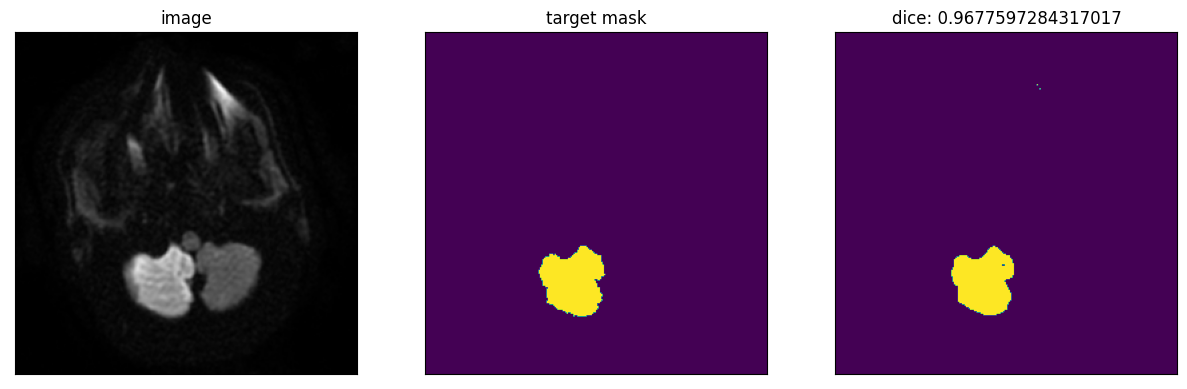

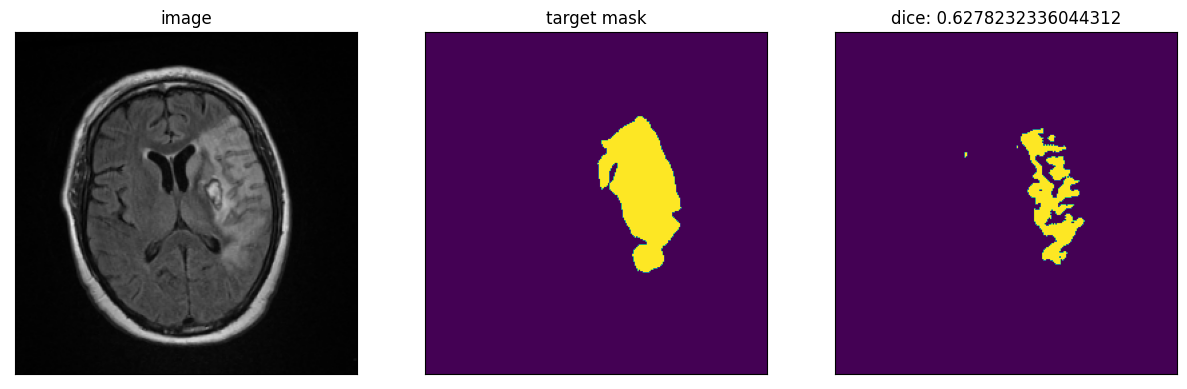

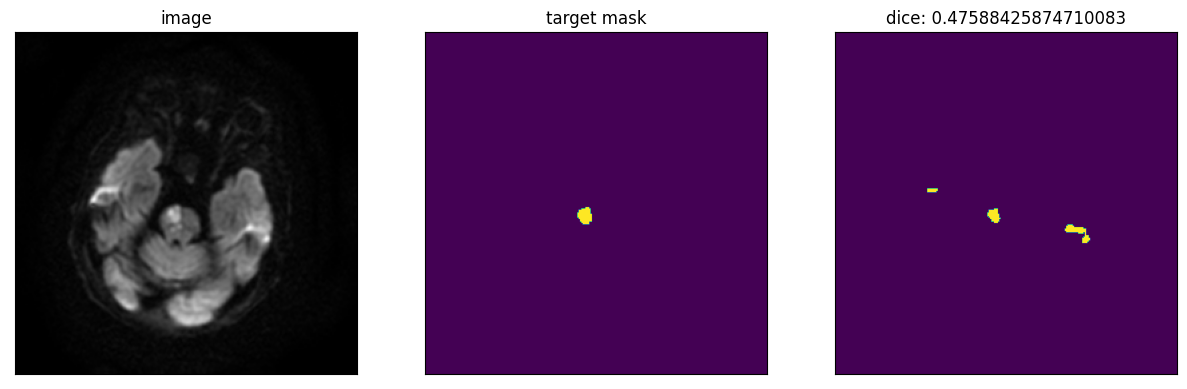

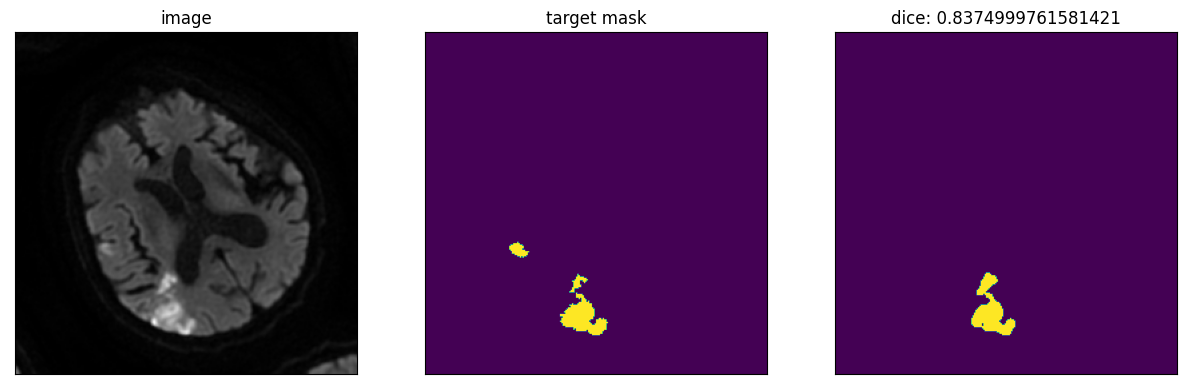

In [19]:
for i in range(4):
    image, target_mask = train_dataset[np.random.randint(0, 100)]
    show_three(model=model, 
               img_list=[(image, target_mask)], 
               device=DEVICE)